# Set Up Data (Follow from Binary Classification Example in Probit Paper pg.31)

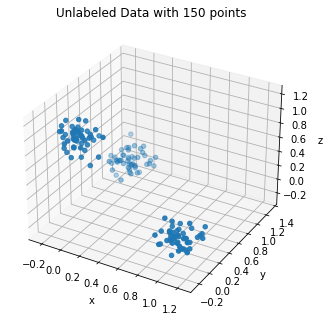

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

N = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N_total = N*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N_total)
ys = np.random.normal(mu, sigma, N_total)
zs = np.random.normal(mu, sigma, N_total)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N] += 1; ys[N:2*N] += 1; zs[2*N:3*N] += 1

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs, ys, zs)
ax.set_title('Unlabeled Data with ' + str(N_total) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

X = np.array([xs,ys,zs])

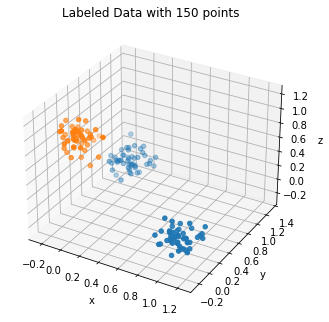

In [2]:
# Set up Data

u_dagger = np.append(np.ones(2*N), -1*np.ones(N))
Z_prime = np.array([0,50,100]) # Indices of labels
y = np.sign(u_dagger[Z_prime]) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N], ys[:2*N], zs[:2*N], 'r')
ax.scatter(xs[2*N:3*N], ys[2*N:3*N], zs[2*N:3*N], 'b')
ax.set_title('Labeled Data with ' + str(N_total) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

In [10]:
from numpy.linalg import matrix_power

# Construct Proximity graph on data

# Euclidean dist^2
def euclid (x1,x2,y1,y2,z1,z2):
    return (x1-x2)**2+(y1-y2)**2+(z1-z2)**2

# returns perturbed kernel k_eps(|x_i - x_j|) (61) 
# where dist = |x_i - x_j| and r is tolerance
def kappa(dist, r, eps):
    '''
    k_eps(t)(61) in paper
    r - threshold in function
    eps - gives perturbed kernel if eps != 0
    '''
    w_ij = 0
    if dist<=r:
        w_ij = 1
    w_ij += eps*np.exp(-dist/(r+eps)**2)
    return w_ij

# Weight function returned by kernel Function 
def weight(X, Y, Z, r, eps = 0):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| (61) in paper
    X, Y, Z - vectors containing x, y, z of all data (assume same size)
    r - threshold in function
    eps - gives perturbed kernel if eps != 0
    '''
    N = X.size
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(i, N):
            dist = euclid(X[i],X[j],Y[i],Y[j],Z[i],Z[j])
#             # kappa function
#             if dist<=r:
#                 W[i][j] = 1
#             W[i][j] += eps*np.exp(-dist/(0.25+eps)**2)
            W[i][j] = kappa(dist, r, eps)
    W = W + W.T
    np.fill_diagonal(W, 0)
    return W

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma 
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1/g*X)+1)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1/g*np.exp(-1/g*X)*np.reciprocal(np.exp(-1/g*X)+1)**2
    
def F_sum(N, g, y, Z_p, u):
    '''
    N - size of vector
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    Fj = np.zeros(N)
    basis = np.eye(N)
    for j,Z_j in enumerate(Z_p):
        Fj = Fj + y[j]*psi(y[j]*u[Z_j], g)/cap_psi(y[j]*u[Z_j], g)*basis[Z_j]
    
    return Fj


# Solving Euler-Lagrange Directly

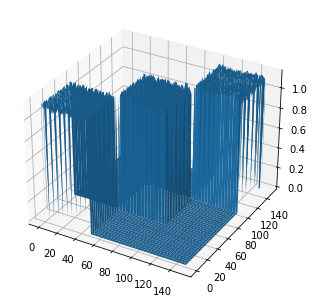

In [11]:
from numpy import linalg
import scipy.optimize
from time import perf_counter

# Initial Parameters
eps = 0.15
rval = 0.25 #threshold for kernel
tau = 1
alpha = 1
g = 0.5 #Noise standard deviation
n_eig = 20 #(62) truncation

# Calculating Weight Matrix
W = weight(xs, ys, zs, rval, eps)

# Print figure of weight
Wx = Wy = np.linspace(0, 150, 150)
X, Y = np.meshgrid(Wx, Wy)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, W)
plt.show()

# Note that this follows Probit Dimension Reduction (Corollary 11)

D = np.diag(W.sum(axis=1))
L = D - W
LE, LV = np.linalg.eig(L)

CE = (1/tau**2*(LE + tau**2))**alpha
C = np.zeros((N_total,N_total))
for k in range(n_eig):
    C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    
def final(u):
    return u - C@F_sum(N_total, g, y, Z_prime, u)

x_0 = np.zeros(N_total)
time_start = perf_counter()
u_ast_full = scipy.optimize.fsolve(final, x_0, full_output=True)
u_ast = u_ast_full[0]
EL_time = (perf_counter() - time_start)


# Using Newtons's Method

In [12]:
import autograd.numpy as np
import autograd
# Not using dimension-reduced probit

# Newtons method function
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - inputfunction
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
#         print(np.linalg.norm(step))

        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

def misfit(u, y, Z_p, g):
    '''
    Misfit function defined in (45)
    N - size of vector
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0
    for j,Z_j in enumerate(Z_p):
        S = S - np.log(cap_psi(y[j]*u[Z_j],g))
        
    return S
    

def probit_min(u):
    # Minimizer u for problem defined in (3)
    
    # inverse of Covariance 
    C_inv = (1/tau**2*(L + tau**2*np.eye(N_total)))**alpha
    uast = 1/2*np.dot(u, C_inv@u) + misfit(u, y, Z_prime, g)
    return uast

x_0 = np.zeros(N_total)

time_start = perf_counter()
u_ast_newt = newton(probit_min, x_0)
Newton_time = (perf_counter() - time_start)


Classification error for EL: 0.0
Classification error for Newtons: 0.0

Computation time for EL: 0.03717125399998622
Computation time for Newton's Method: 0.4221263709999903


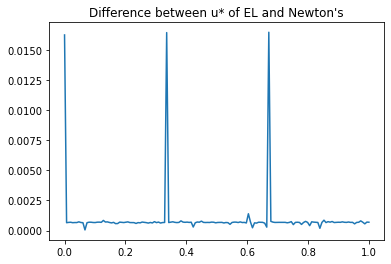

index: 0 | newton: 0.01961822744928203 | EL: 0.035855847297845196
index: 50 | newton: 0.019653970686294393 | EL: 0.03608724914941215
index: 100 | newton: -0.01960202774326378 | EL: -0.03606423712328723


In [13]:
# Compute average prediction error 

pred_error1 =  (sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(N_total)*100)
pred_error2 =  (sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(2*N_total)*100)
print('Classification error for EL: ' + str(pred_error1))
print('Classification error for Newtons: ' + str(pred_error2))

print('\nComputation time for EL: ' + str(EL_time))
print('Computation time for Newton\'s Method: ' + str(Newton_time))

# Plot EL method vs Newton's method
plt.plot(np.linspace(0,1,N_total), np.abs(u_ast_newt-u_ast))
plt.title("Difference between u* of EL and Newton's")
plt.show()

# print when error big
tol = 0.01
for j in range(N_total):
    if np.abs(u_ast_newt[j]-u_ast[j]) > tol:
        print("index: " + str(j) + " | newton: "+ str(u_ast[j]) 
              + " | EL: "+ str(u_ast_newt[j]))